<a href="https://colab.research.google.com/github/Fawad98/Data-Science-Projects/blob/main/AnimalIdenfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use Pytorch", torch.__version__)

Libraries imported - ready to use Pytorch 1.9.0+cpu


4 classes:
['elephant', 'giraffe', 'lion', 'zebra']


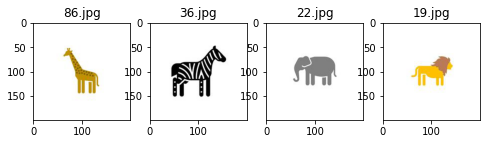

In [ ]:
data_path = '/content/drive/MyDrive/data/AnimalDataset/training/'

classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

fig = plt.figure(figsize=(8,12))
i=0
for sub_dir in os.listdir(data_path):
  i+=1
  img_file = os.listdir(os.path.join(data_path, sub_dir))[0]
  img_path = os.path.join(data_path, sub_dir, img_file)
  img = mpimg.imread(img_path)
  a = fig.add_subplot(1, len(classes), i)
  imgplot = plt.imshow(img)
  a.set_title(img_file)
plt.show()


In [ ]:
def load_dataset(data_path):
  transformation = transforms.Compose(
      [
          transforms.ToTensor(),
       transforms.Normalize(mean=[0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
      ]
  )

  full_dataset = torchvision.datasets.ImageFolder(
      root = data_path,
      transform = transformation
  )

  train_size = int(0.7*len(full_dataset))
  test_size = len(full_dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=50,
      num_workers=0,
      shuffle=False
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=50,
      num_workers=0,
      shuffle=False
  )

  return train_loader, test_loader

train_loader, test_loader = load_dataset(data_path)
print("Data Loaders Ready!")

Data Loaders Ready!


In [ ]:
class Net(nn.Module):
  def __init__(self, num_classes=4):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride = 1, padding=1 )

    self.pool = nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, stride = 1, padding = 1)

    self.conv3 = nn.Conv2d(in_channels = 12, out_channels=24, kernel_size = 3, stride =1, padding =1)

    self.drop = nn.Dropout2d(p=0.2)

    self.fc = nn.Linear(in_features = 50*50*24, out_features = num_classes)


  def forward(self, x):

    x = F.relu(self.pool(self.conv1(x)))

    x = F.relu(self.pool(self.conv2(x)))

    x = F.relu(self.drop(self.conv3(x)))

    x = F.dropout(x,training = self.training)

    x = x.view(-1,50*50*24)

    x = self.fc(x)

    return F.log_softmax(x,dim=1)

print('CNN Model Class Defined!')

CNN Model Class Defined!


In [ ]:
from torch import optim
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  train_loss=0
  print('Epoch:', epoch)

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    output = model(data)

    loss = loss_criteria(output, target)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0:
      print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(batch_idx * len(data), len(train_loader.dataset),
                                                                 100.*batch_idx / len(train_loader), loss.item()))
  avg_loss = train_loss / (batch_idx+1)
  print('Training set: Average loss: {:.6f}'.format(avg_loss))
  return avg_loss

def test(model, device, test_loader):
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    batch_count=0
    for data, target in test_loader:
      batch_count += 1
      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += loss_criteria(output,target).item()

      _, predicted = torch.max(output.data, 1)
      correct += torch.sum(target==predicted).item()

  avg_loss = test_loss/batch_count
  print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%\n'.format(
      avg_loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)
  ))

  return avg_loss

device = 'cpu'
if(torch.cuda.is_available()):
  device="cuda"
print('Training on:', device)

model = Net(num_classes = len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_criteria = nn.CrossEntropyLoss()

epoch_nums = []
training_loss = []
validation_loss = []

epochs = 5
for epoch in range(1, epochs+1):
      train_loss = train(model, device, train_loader, optimizer, epoch)
      test_loss = test(model, device, test_loader)
      epoch_nums.append(epoch)
      training_loss.append(train_loss)
      validation_loss.append(test_loss)
      

Training on: cpu
Epoch: 1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training set [0/277 (0%)] Loss: 1.381351
Training set: Average loss: 1.349489
Validation set: Average loss: 1.037366, Accuracy: 75/119 (63%

Epoch: 2
Training set [0/277 (0%)] Loss: 1.222507
Training set: Average loss: 0.672784
Validation set: Average loss: 0.211439, Accuracy: 119/119 (100%

Epoch: 3
Training set [0/277 (0%)] Loss: 0.276926
Training set: Average loss: 0.148413
Validation set: Average loss: 0.039016, Accuracy: 119/119 (100%

Epoch: 4
Training set [0/277 (0%)] Loss: 0.067577
Training set: Average loss: 0.037146
Validation set: Average loss: 0.006019, Accuracy: 119/119 (100%

Epoch: 5
Training set [0/277 (0%)] Loss: 0.022814
Training set: Average loss: 0.036501
Validation set: Average loss: 0.001703, Accuracy: 119/119 (100%



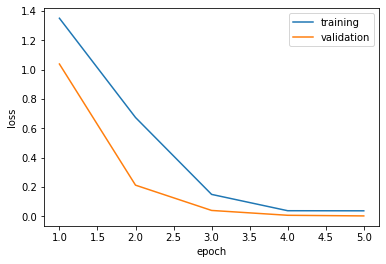

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


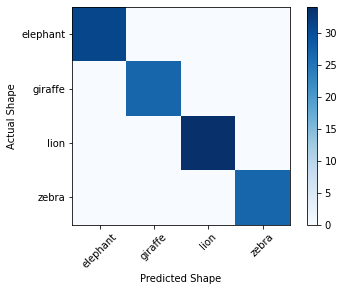

In [ ]:
from sklearn.metrics import confusion_matrix


model.eval()

print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 


cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

In [ ]:
# Save the model weights
model_file = 'animal_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as animal_classifier.pt


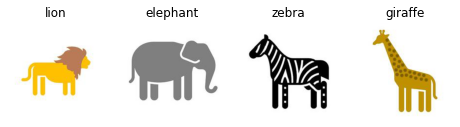

In [ ]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Default value
    index = 0
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Load your model
model = Net()
model.load_state_dict(torch.load(model_file))

# The images are in the data/shapes folder
test_data_path = '/content/drive/MyDrive/data/AnimalDataset/test/'

# Show the test images with predictions
fig = plt.figure(figsize=(8, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(model, np.array(img))
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()